In [1]:
import json

import pandas as pd

In [2]:
hotels = pd.read_csv('hotels.csv')
hotels.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


Смотрим на пропуски

In [3]:
hotels.isna().sum().sort_values(ascending=False)

lng                                           2448
lat                                           2448
positive_review                                  0
days_since_review                                0
tags                                             0
reviewer_score                                   0
total_number_of_reviews_reviewer_has_given       0
review_total_positive_word_counts                0
hotel_address                                    0
additional_number_of_scoring                     0
review_total_negative_word_counts                0
negative_review                                  0
reviewer_nationality                             0
hotel_name                                       0
average_score                                    0
review_date                                      0
total_number_of_reviews                          0
dtype: int64

Заполняем пропуски значениями из словарей, заранее подготовленных скриптом prepare_lat_lng_dicts.py с применением библиотеки geopy

In [4]:
with open("lng_dict.json", "r") as infile:
    lng_dict = json.load(infile)

In [5]:
with open("lat_dict.json", "r") as infile:
    lat_dict = json.load(infile)

In [6]:
missings_idx = hotels[hotels.lng.isna()].index
hotels.loc[missings_idx, 'lat'] = hotels.loc[missings_idx, 'hotel_address'].map(lat_dict)
hotels.loc[missings_idx, 'lng'] = hotels.loc[missings_idx, 'hotel_address'].map(lng_dict)

In [7]:
hotels.isna().sum().sum()

0

От пропусков избавились. Обратим внимание на признаки, представленные в виде строк:

Дополним датасет данными о стране и городе, в которых располагается отель

In [57]:
with open("countries.json", "r", encoding='UTF-8') as infile:
    countries = json.load(infile)

with open("cities.json", "r", encoding='UTF-8') as infile:
    cities = json.load(infile)

In [51]:
hotels['hotel_country'] = hotels.hotel_name.map(countries)
hotels['hotel_city'] = hotels.hotel_name.map(cities)

In [52]:
hotels.hotel_country.value_counts()

United Kingdom    196774
France             44830
Nederland          43006
Espanya            35356
Österreich         28956
Italia             27836
España             10045
Name: hotel_country, dtype: int64

In [53]:
hotels.hotel_city.value_counts()

London                      140937
Barcelona                    45307
Paris                        39652
Amsterdam                    35914
Milano                       22307
                             ...  
Vanves                          29
Montrouge                       25
Paris 4e Arrondissement         18
Paris 10e Arrondissement         7
Ottakring                        6
Name: hotel_city, Length: 62, dtype: int64

In [55]:
hotels.isna().sum().sum()

0

Пропусков нет

Добавим данные о расстояниях от отелей до центров городов

In [58]:
from geopy.geocoders import ArcGIS

In [59]:
from geopy.distance import geodesic

In [60]:
locator = ArcGIS(user_agent='myGeocoder')

In [73]:
def get_distance(lat1, lng1, lat2, lng2):
    distance = geodesic(
        (lat1, lng1),
        (lat2, lng2)
    ).kilometers
    
    return distance

In [65]:
from tqdm import tqdm

In [70]:
hotels['hotel_location'] = f'{hotels.hotel_city},{hotels.hotel_country}'

In [72]:
hotels_cities_centers_lats = {}
hotels_cities_centers_lngs = {}

for location in tqdm(hotels.hotel_location.unique()):
    city_center_coordinates = locator.geocode(location)
    hotels_cities_centers_lats[location] = city_center_coordinates.latitude
    hotels_cities_centers_lngs[location] = city_center_coordinates.longitude


100%|██████████| 63/63 [00:47<00:00,  1.32it/s]


In [75]:
hotels['city_center_lat'] = hotels['hotel_location'].map(hotels_cities_centers_lats)
hotels['city_center_lng'] = hotels['hotel_location'].map(hotels_cities_centers_lngs)


In [78]:
tqdm.pandas()

In [79]:
hotels['dist_to_center'] = hotels[['city_center_lat', 'city_center_lng', 'lat', 'lng']].progress_apply(
    lambda x: get_distance(
        x['city_center_lat'],
        x['city_center_lng'],
        x['lat'],
        x['lng']
    ),
    axis=1
)

100%|██████████| 386803/386803 [01:18<00:00, 4930.53it/s]


In [80]:
hotels.isna().sum().sum()

0

In [81]:
hotels.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   negative_review    386803 non-null  object
 1   positive_review    386803 non-null  object
 2   tags               386803 non-null  object
 3   days_since_review  386803 non-null  object
 4   neg_scores         386803 non-null  object
 5   pos_scores         386803 non-null  object
 6   hotel_country      386803 non-null  object
 7   hotel_city         386803 non-null  object
 8   hotel_location     386803 non-null  object
dtypes: object(9)
memory usage: 26.6+ MB


Начнём с hotel_address

In [9]:
hotels.hotel_address.describe()

count                                                386803
unique                                                 1493
top       163 Marsh Wall Docklands Tower Hamlets London ...
freq                                                   3587
Name: hotel_address, dtype: object

Сравним с hotel_name:

In [10]:
hotels.hotel_name.describe()

count                                         386803
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            3587
Name: hotel_name, dtype: object

Видим, что количество уникальных значений адресов и названий отелей практически совпадает. Разница в 1 единицу на весь датасет. Поэтому от одного из этих признаков можно избавиться, предварительно выделив из адреса, например, населенный пункт и страну.Но снасала выясним, с чем связана эта разница.

In [11]:
hotels.groupby('hotel_address')[['hotel_name']].nunique().sort_values(by='hotel_name', ascending=False)

,hotel_name
hotel_address,
8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom,2
Hernalser Hauptstra e 105 17 Hernals 1170 Vienna Austria,1
Hoffingergasse 26 28 12 Meidling 1120 Vienna Austria,1
Hobbemakade 50 Oud Zuid 1071 XL Amsterdam Netherlands,1
Hintschiggasse 1 10 Favoriten 1100 Vienna Austria,1
...,...
39 Avenue de l Op ra 2nd arr 75002 Paris France,1
39 Avenue de Wagram 17th arr 75017 Paris France,1
39 40 Dorset Square Hotel Westminster Borough London NW1 6QN United Kingdom,1


Видим, что по адресу '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom' значатся два различных отеля. Посмотрим на них:

In [12]:
hotels[hotels.hotel_address == '8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'].hotel_name.unique()

array(['The Grand at Trafalgar Square',
       'Club Quarters Hotel Trafalgar Square'], dtype=object)

In [13]:
hotels[hotels.hotel_name == 'The Grand at Trafalgar Square'].hotel_address.unique()


array(['8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'],
      dtype=object)

In [14]:
hotels[hotels.hotel_name == 'Club Quarters Hotel Trafalgar Square'].hotel_address.unique()

array(['8 Northumberland Avenue Westminster Borough London WC2N 5BY United Kingdom'],
      dtype=object)

Да, видим, что действительно по одному адресу находятся два разных отеля. Проверка в интернет показала, что оба реальные и работают.

Это говорит о том, что:
1. Название отеля лучше определяет его чем адрес;
2. От адреса можно будет избавиться после выделения из него страны и населенного пункта. Но сделать это гораздо легче, взяв информацию из lng и lat. Так что от адреса избавляемся однозначно.

Сделаем это:

In [15]:
hotels.drop(columns=['hotel_address'], inplace=True)

Теперь поработаем с review_date:

In [16]:
hotels.review_date = pd.to_datetime(hotels.review_date)
hotels.review_date.describe()

/tmp/ipykernel_216941/1026588098.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  hotels.review_date.describe()


count                  386803
unique                    731
top       2017-08-02 00:00:00
freq                     1911
first     2015-08-04 00:00:00
last      2017-08-03 00:00:00
Name: review_date, dtype: object

In [17]:
hotels.review_date

0        2016-02-19
1        2017-01-12
2        2016-10-18
3        2015-09-22
4        2016-03-05
            ...    
386798   2017-04-19
386799   2017-02-13
386800   2016-02-07
386801   2017-05-21
386802   2016-08-05
Name: review_date, Length: 386803, dtype: datetime64[ns]

Лучше этот признак сразу разбить на три числовых:
1. year - год;
2. month - месяц;
3. day - день,

а затем избавиться от него.

Сделаем это:

In [18]:
hotels['year'] = hotels.review_date.dt.year
hotels['month'] = hotels.review_date.dt.month
hotels['day'] = hotels.review_date.dt.day

In [19]:
hotels.drop(columns=['review_date'], inplace=True)

Название отеля приведем к категориальному типу:

In [20]:
hotels.hotel_name = hotels.hotel_name.astype('category')

Национальность оставивщего обзор тоже приведем к категориальному типу:

In [21]:
hotels.reviewer_nationality = hotels.reviewer_nationality.astype('category')

Поработаем с негативной частью обзора:

In [22]:
pd.set_option('display.max_rows', None)

In [23]:
hotels.negative_review.value_counts().head(100)

No Negative                          95907
 Nothing                             10737
 Nothing                              3154
 nothing                              1660
 N A                                   802
 None                                  737
                                       606
 N a                                   384
 Breakfast                             296
 Small room                            283
 Location                              281
 All good                              251
 Everything                            251
 Nothing really                        240
 none                                  223
 nothing                               219
 No complaints                         201
 Nil                                   197
 Nothing really                        195
 Price                                 192
 n a                                   176
 Nothing to dislike                    159
 Nothing at all                        154
 Nothing at

In [24]:
pd.set_option('display.max_rows', 10)

Первое, что мы видим - это необходимость избавиться от ведущих и замыкающих пробелов и привести все к нижнему регистру. Сделаем это:

In [25]:
hotels.negative_review = hotels.negative_review.apply(lambda x: x.strip().lower())

Посмотрим на частоты вариантов негативных отзывов еще раз:

In [26]:
hotels.negative_review.value_counts().head(100)


no negative         95907
nothing             15882
n a                  1392
none                 1115
                      606
                    ...  
nothing to say         52
room a bit small       52
no problems            52
no comment             50
no pool                49
Name: negative_review, Length: 100, dtype: int64

Сложность этого признака заключается в том, что он может носить как положительную, так и отрицательную окраску. Работа с этим признаком относится к задачам обработки естественных языков (NLP). Для решения этой задачи воспользуемся библиотекой nltk, как описано в <a href="https://towardsdatascience.com/sentiment-analysis-for-hotel-reviews-3fa0c287d82e">статье</a>.

Также видим, что есть очень часто повторяющиеся значения, а есть уникальные отзывы. К последним доверия больше. Хороший признак, который это учтёт - доля таких озывов от общего количества уникальных отзывов.

Еще одним признаком станет количество слов в негативном отзыве.

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [28]:
# Первым делов подправим явные выражения 
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('No Negative', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(lambda x: x.replace('N A', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('All good', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('No complaints', 'Positive'))
hotels['negative_review'] = hotels['negative_review'].apply(
    lambda x: x.replace('Nothing to dislike', 'Positive'))
hotels['positive_review'] = hotels['positive_review'].apply(
    lambda x: x.replace('No Positive', 'Negative'))

In [29]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/alexey/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [31]:
# создаем два экземпляра анализатора, чтобы разделить лексикон
# для разной системы оценки положительных и отрицательных отзывов:
sia_neg = SentimentIntensityAnalyzer()
sia_pos = SentimentIntensityAnalyzer()

hotels['neg_scores'] = hotels['negative_review'].apply(
    lambda x: sia_neg.polarity_scores(x))
hotels['pos_scores'] = hotels['positive_review'].apply(
    lambda x: sia_pos.polarity_scores(x))

# формируем новые признаки:
hotels['n_review_sentiments_neg'] = hotels['neg_scores'].apply(lambda x: x['neg'])
hotels['n_review_sentiments_neu'] = hotels['neg_scores'].apply(lambda x: x['neu'])
hotels['n_review_sentiments_pos'] = hotels['neg_scores'].apply(lambda x: x['pos'])
hotels['n_review_sentiments_compound'] = hotels['neg_scores'].apply(
    lambda x: x['compound'])

hotels['p_review_sentiments_neg'] = hotels['pos_scores'].apply(lambda x: x['neg'])
hotels['p_review_sentiments_neu'] = hotels['pos_scores'].apply(lambda x: x['neu'])
hotels['p_review_sentiments_pos'] = hotels['pos_scores'].apply(lambda x: x['pos'])
hotels['p_review_sentiments_compound'] = hotels['pos_scores'].apply(
    lambda x: x['compound'])


In [33]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                386803 non-null  int64   
 1   average_score                               386803 non-null  float64 
 2   hotel_name                                  386803 non-null  category
 3   reviewer_nationality                        386803 non-null  category
 4   negative_review                             386803 non-null  object  
 5   review_total_negative_word_counts           386803 non-null  int64   
 6   total_number_of_reviews                     386803 non-null  int64   
 7   positive_review                             386803 non-null  object  
 8   review_total_positive_word_counts           386803 non-null  int64   
 9   total_number_of_reviews_reviewer_has_given  386803 non-null

В отличие от подхода в приведенной выше статье для экономии времени расчета мы подготовим словари, в которых ключами будут варианты отзывов из списка уникальных, а значениями будет метрика compund, которая дает отрицательные значения при негативной окраске, положительные при позитивной и близкие к нулю при нейтральной. Затем применим этот словарь для создания нового признака nr_sentiment_score.

In [30]:
# from tqdm import tqdm

# nr_sentiment_dict = {}
# negative_reviews = hotels.negative_review.unique()

# for negative_review in tqdm(negative_reviews):
#     nr_sentiment_dict[negative_review] = sia.polarity_scores(negative_review)['compound']


In [31]:
# from tqdm import tqdm
# from textblob import TextBlob

# nr_sentiment_dict = {}
# negative_reviews = hotels.negative_review.unique()

# for negative_review in tqdm(negative_reviews):
#     blob = TextBlob(negative_review)
#     for sentence in blob.sentences:
#         nr_sentiment_dict[negative_review] = sentence.sentiment.polarity

100%|██████████| 243719/243719 [01:16<00:00, 3189.36it/s]


In [32]:
# from itertools import islice

In [33]:
# dict(islice(nr_sentiment_dict.items(), 0, 20))

{'leaving': 0.0,
 'poor breakfast': -0.4,
 'no kettle in room': 0.0,
 'no negative': 0.15,
 'torn sheets': 0.0,
 'nothing': 0.0,
 'nothing it was lovely': 0.5,
 'the communal areas are a bit soul less and the breakfast whilst very good is expensive but you can always use the cafe at the tram stop elise i think for breakfast and late night drinks we did': -0.014166666666666675,
 'undergoing refurbishment no tea coffer in room room very small no ramp at entrance for wheeled suitcases no coffee available in lounge next morning early checkout at 11 00am': 0.043750000000000004,
 'i advised it was for my husbands birthday and reception gave us a twin room when i booked a double i asked for little extras to be put in the room for his birthday and it was given too late and didnt make it special': -0.03258928571428571,
 'they have lost their license and cannot sell alcohol or change your currency': 0.0,
 'feel there isnt much to be improved upon with this hotel excellent all round': 0.333333333

Проделаем такую же работу для positive_review

In [34]:
# hotels.positive_review = hotels.positive_review.apply(
#     lambda x: x.strip().lower())

In [35]:
# pr_sentiment_dict = {}
# positive_reviews = hotels.positive_review.unique()

# for positive_review in tqdm(positive_reviews):
#     blob = TextBlob(positive_review)
#     for sentence in blob.sentences:
#         pr_sentiment_dict[positive_review] = sentence.sentiment.polarity

100%|██████████| 303584/303584 [01:30<00:00, 3351.23it/s]


К сожалению констатируем, что оценки далеки от реальности. Видим, что nothing сильно портит картину. Попробуем включить его в стоп-слова.

In [36]:
hotels['nr_sentiment_score'] = hotels.negative_review.map(nr_sentiment_dict)
hotels['pr_sentiment_score'] = hotels.positive_review.map(pr_sentiment_dict)

In [37]:
nr_frequencies = hotels.negative_review.value_counts(normalize=True)
nr_frequencies_dict = dict(zip(nr_frequencies.index, nr_frequencies.values))
hotels['nr_frequency'] = hotels.negative_review.map(nr_frequencies_dict)

pr_frequencies = hotels.positive_review.value_counts(normalize=True)
pr_frequencies_dict = dict(zip(pr_frequencies.index, pr_frequencies.values))
hotels['pr_frequency'] = hotels.positive_review.map(pr_frequencies_dict)

Удалим колонки с отзывами

In [41]:
hotels.drop(columns=['negative_review', 'positive_review'], inplace=True)

In [42]:
hotels.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   tags    386803 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


Обработаем признак days_since_rewiev

In [40]:
hotels['days_since_review'] = hotels['days_since_review'].str.split().str[0]
hotels['days_since_review'] = hotels['days_since_review'].astype('int')


Обработаем признак tags

In [43]:
hotels.tags

0         [' Leisure trip ', ' Couple ', ' Studio Suite ...
1         [' Business trip ', ' Couple ', ' Standard Dou...
2         [' Leisure trip ', ' Solo traveler ', ' Modern...
3         [' Leisure trip ', ' Solo traveler ', ' Standa...
4         [' Business trip ', ' Couple ', ' Standard Dou...
                                ...                        
386798    [' Leisure trip ', ' Group ', ' Club Double or...
386799    [' Leisure trip ', ' Couple ', ' Standard Doub...
386800    [' Business trip ', ' Solo traveler ', ' Singl...
386801    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
386802    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 386803, dtype: object

In [44]:
def re_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

hotels['tags'] = hotels['tags'].apply(re_func)

In [45]:
hotels.tags

0         [Leisure trip, Couple, Studio Suite, Stayed 2 ...
1         [Business trip, Couple, Standard Double Room, ...
2         [Leisure trip, Solo traveler, Modern Double Ro...
3         [Leisure trip, Solo traveler, Standard Room wi...
4         [Business trip, Couple, Standard Double or Twi...
                                ...                        
386798    [Leisure trip, Group, Club Double or Twin Room...
386799    [Leisure trip, Couple, Standard Double Room, S...
386800    [Business trip, Solo traveler, Single Room, St...
386801    [Leisure trip, Solo traveler, Deluxe Double Ro...
386802    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 386803, dtype: object

In [46]:
hotels_copy = hotels.explode('tags')
tags_counts = hotels_copy['tags'].value_counts()[:20]
hotels_tags_counts = pd.DataFrame(tags_counts).reset_index()
hotels_tags_counts.columns = ['unique_tags', 'counts_unique_tags']
top_tags = set(hotels_tags_counts['unique_tags'])

In [48]:
hotels_copy.tags.nunique()

2368

In [52]:
hotels_copy[hotels_copy.tags.apply(lambda x: 'Stayed' in x)][['tags']].value_counts()

tags            
Stayed 1 night      145373
Stayed 2 nights     100263
Stayed 3 nights      72000
Stayed 4 nights      35748
Stayed 5 nights      15611
                     ...  
Stayed 26 nights         6
Stayed 23 nights         6
Stayed 24 nights         5
Stayed 25 nights         4
Stayed 29 nights         3
Length: 30, dtype: int64

In [49]:
hotels_copy.tags.value_counts()

Leisure trip                         313593
Submitted from a mobile device       230778
Couple                               189212
Stayed 1 night                       145373
Stayed 2 nights                      100263
                                      ...  
Studio with Spa Access                    1
Comfort Family Room                       1
Junior Suite Free Wifi                    1
Design Suite                              1
Executive Double Room Non Smoking         1
Name: tags, Length: 2368, dtype: int64

In [53]:
# Используем эти 20 тегов что бы создать в нашем датасете 20 новых признаков
# 1 -  в отзыве есть этот тег, 0 - тега нет

for tag in top_tags:
    tag_name = str(tag)
    hotels[tag_name] = hotels['tags'].apply(lambda x: 1 if tag_name in x else 0)


In [54]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 40 columns):
 #   Column                                      Non-Null Count   Dtype   
---  ------                                      --------------   -----   
 0   additional_number_of_scoring                386803 non-null  int64   
 1   average_score                               386803 non-null  float64 
 2   hotel_name                                  386803 non-null  category
 3   reviewer_nationality                        386803 non-null  category
 4   review_total_negative_word_counts           386803 non-null  int64   
 5   total_number_of_reviews                     386803 non-null  int64   
 6   review_total_positive_word_counts           386803 non-null  int64   
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  int64   
 8   reviewer_score                              386803 non-null  float64 
 9   tags                                        386803 non-null

Для тестирования промежуточного результата избавимся от оставщихся строковых данных.

In [39]:
hotels = hotels.select_dtypes([], ['object'])

In [40]:
hotels.hotel_name = hotels.hotel_name.cat.codes
hotels.reviewer_nationality = hotels.reviewer_nationality.cat.codes

In [41]:
hotels.nr_sentiment_score.fillna(0, inplace=True)
hotels.pr_sentiment_score.fillna(0, inplace=True)


In [42]:
hotels.head()

,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,year,month,day,nr_sentiment_score,pr_sentiment_score,nr_frequency,pr_frequency
0,581,8.4,1366,213,3,1994,4,7,10.0,51.507894,-0.143671,2016,2,19,0.00,0.600000,0.000460,0.000075
1,299,8.3,975,213,3,1361,2,14,6.3,51.521009,-0.123097,2017,1,12,-0.40,0.000000,0.000189,0.022862
2,32,8.9,909,42,6,406,0,14,7.5,48.845377,2.325643,2016,10,18,0.00,-0.113636,0.000047,0.069506
3,34,7.5,983,213,0,607,11,8,10.0,48.888697,2.394540,2015,9,22,0.15,0.428333,0.247948,0.000003
4,914,8.5,349,160,4,7586,20,10,9.6,52.385601,4.847060,2016,3,5,0.00,0.277500,0.000003,0.000003


In [43]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(columns=['reviewer_score'])  
y = hotels['reviewer_score'] 

In [44]:
X.isna().sum()

additional_number_of_scoring                  0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
review_total_negative_word_counts             0
total_number_of_reviews                       0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
lat                                           0
lng                                           0
year                                          0
month                                         0
day                                           0
nr_sentiment_score                            0
pr_sentiment_score                            0
nr_frequency                                  0
pr_frequency                                  0
dtype: int64

Отбор признаков

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   hotel_name                                  386803 non-null  int16  
 3   reviewer_nationality                        386803 non-null  int16  
 4   review_total_negative_word_counts           386803 non-null  int64  
 5   total_number_of_reviews                     386803 non-null  int64  
 6   review_total_positive_word_counts           386803 non-null  int64  
 7   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

In [46]:
X.additional_number_of_scoring.nunique()

480

In [47]:
X.average_score.nunique()

34

In [48]:
X.total_number_of_reviews_reviewer_has_given.nunique()

194

In [49]:
X.lat.nunique()

1488

In [50]:
X.lng.nunique()

1488

In [55]:
X.hotel_name.nunique()

1492

In [51]:
y=y.astype('int')

In [52]:
num_cols = [
    'review_total_negative_word_counts',
    'total_number_of_reviews',
    'review_total_positive_word_counts',
    'nr_sentiment_score',
    'pr_sentiment_score',
    'nr_frequency',
    'pr_frequency',
    'average_score',
    'lat',
    'lng',
    'year',
    'month',
    'day',
]

cat_cols = [
    'additional_number_of_scoring',
    'hotel_name',
    'reviewer_nationality',
    'total_number_of_reviews_reviewer_has_given',
]

array([[ 581, 1366],
       [ 299,  975],
       [  32,  909],
       ...,
       [ 457,  177],
       [ 365, 1364],
       [ 222, 1371]])

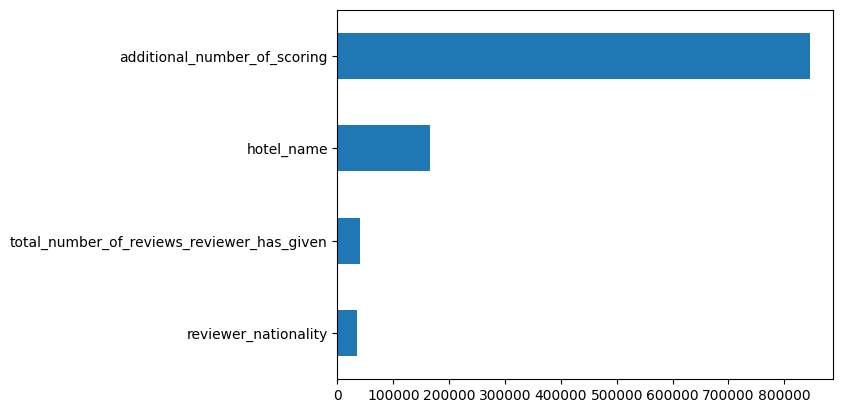

In [61]:
from sklearn.feature_selection import chi2, SelectKBest

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

X_cat = SelectKBest(chi2, k=2).fit_transform(X[cat_cols], y)
X_cat


array([[3.00000000e+00, 1.99400000e+03, 4.00000000e+00, ...,
        4.60182574e-04, 7.49735654e-05, 8.40000000e+00],
       [3.00000000e+00, 1.36100000e+03, 2.00000000e+00, ...,
        1.88726561e-04, 2.28617668e-02, 8.30000000e+00],
       [6.00000000e+00, 4.06000000e+02, 0.00000000e+00, ...,
        4.65353164e-05, 6.95056657e-02, 8.90000000e+00],
       ...,
       [1.20000000e+01, 2.75100000e+03, 9.00000000e+00, ...,
        2.58529536e-06, 2.58529536e-06, 6.80000000e+00],
       [0.00000000e+00, 1.56700000e+03, 6.00000000e+00, ...,
        2.47947922e-01, 2.58529536e-06, 8.10000000e+00],
       [2.00000000e+01, 1.20900000e+03, 2.00000000e+01, ...,
        2.58529536e-06, 2.58529536e-06, 9.00000000e+00]])

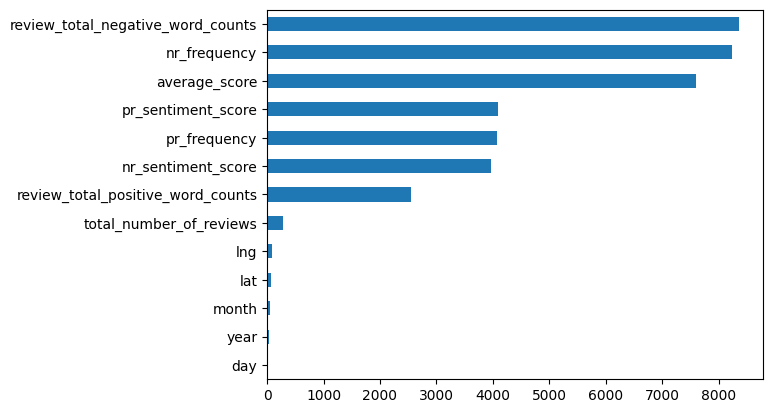

In [62]:
from sklearn.feature_selection import f_classif  # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

X_num = SelectKBest(f_classif, k=8).fit_transform(X[num_cols], y)
X_num


In [63]:
import numpy as np

In [65]:
X_best = np.concatenate((X_cat, X_num), axis=1)
X_best.shape

(386803, 10)

In [66]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [67]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.25, random_state=42)

In [70]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

# Создаём модель  
regr = RandomForestRegressor(n_estimators=100, n_jobs=-1)  

# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [71]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.15211122235965358


Пока видим, что удалось снизить метрику до 0,13. Это уже хорошо.